<a href="https://colab.research.google.com/github/jamesemansfield2/bank_transaction_recoveries_rege_nachaucc4a_ai_ml_generative_ai/blob/main/bank_recoveries_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Bank Transaction Recoveries — Categorization, Compliance (Reg E / UCC 4A), Risk Scoring & GenAI (Colab)

**Purpose:** End-to-end, illustrative workflow for banks and fintechs to:
- Generate **synthetic consumer & commercial transaction datasets** with **ACH recovery** metadata (ODFI/RDFI).
- Categorize and construct **timelines** (claims, windows, network responses).
- Compute **compliance flags** under **Reg E** (consumer) vs **UCC Article 4A** (commercial) with **Nacha** overlays.
- Build **aggregates** and **ad-hoc query** helpers (consumer vs commercial; adherence vs at-risk).
- Train a simple **XGBoost** model to score **risk of non-compliance** (illustrative features).
- Use **Generative AI (Gemini)** for summaries and Q&A (optional).

> **Guidance summary (plain English, not legal advice):**
> - **Regulation E (12 CFR 1005)** covers **consumer** electronic fund transfers and sets error-resolution timing (e.g., consumer notice window from the statement showing the error; provisional credit/investigation procedures).
> - **UCC Article 4A** covers **commercial/wholesale** funds transfers (e.g., many wires and commercial EFT contexts), including security procedures, acceptance/finality, cancellation windows, and notice preclusion periods.
> - **Nacha Operating Rules** overlay ACH network procedures for both consumer and commercial ACH. Recent updates allow **ODFI Request for Return** "for any reason" and, effective **Apr 1, 2025**, expect the **RDFI** to advise the ODFI of request **status within 10 banking days**. Returns may be handled on a **same-day** basis (returns are **not** subject to the Same Day ACH entry fee).

**Disclaimer:** Everything here is illustrative. Adapt policy logic, labels, and thresholds to your institution’s policies and counsel.



## 0) Configuration

Edit these to control dataset size and reproducibility.


In [ ]:
N = 100000          # number of synthetic transactions to generate
RANDOM_SEED = 7     # for reproducibility


## 1) Imports & setup


In [ ]:
import os, math, random
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


## 2) Synthetic data generation

This block generates an **illustrative** dataset with:
- Identity: `transaction_id`, `account_id`, `customer_id`, `account_type` (CONSUMER/COMMERCIAL)
- Rail/context: `rail` (ACH/WIRE/CARD), `channel`, `mcc`, `amount`
- Timestamps: `event_ts`, `post_ts`, optional `claim_ts`
- ACH recovery: `odfi_id`, `rdfi_id`, `odfi_request_ts`, `rdfi_status_ts`, `rdfi_status`
- Policy flags: `reg_e_applicable`, `ucc4a_applicable`, `nacha_applicable`
- Derived deadlines: `reg_e_notice_deadline`, `ach_return_deadline`, `rdfi_status_due`
- Labels: `consumer_notice_in_window`, `ach_return_in_window`, `rdfi_status_on_time`, `noncompliant_label` (1 = any applicable window missed)

> **Note:** For simplicity, the "10 banking days" RDFI expectation is modeled as 10 calendar days. Replace with a business day calendar if needed.



## 2A) Optional: Banking-days calculator (weekdays + optional holidays)

By default, the synthetic data modeled the RDFI 10-**banking**-day expectation using **calendar days**.
If you prefer a closer approximation, enable **business days** (Mon–Fri) and pass an optional holiday set.


In [ ]:
from datetime import timezone

start_date = datetime(2025, 6, 1, tzinfo=timezone.utc)
end_date   = datetime(2025, 9, 15, tzinfo=timezone.utc)

rails = ["ACH", "WIRE", "CARD"]
channels = ["ECOM", "POS", "ATM", "P2P", "ACH_WEB", "ACH_PPD", "ACH_CCD"]
mccs = [5411, 5999, 5732, 4812, 5812, 4900, 4899, 4111]
odfis = [f"ODFI{idx:03d}" for idx in range(1, 31)]
rdfis = [f"RDFI{idx:03d}" for idx in range(1, 31)]
reason_codes = ["R10", "R11", "R07", "R08", "R29", "R01", "N/A"]  # illustrative

def rdate(a, b):
    delta = b - a
    secs = random.randint(0, int(delta.total_seconds()))
    return a + timedelta(seconds=secs)

rows = []
for i in range(N):
    is_consumer = np.random.rand() < 0.65
    rail = np.random.choice(rails, p=[0.7, 0.1, 0.2])
    ch = np.random.choice(channels, p=[0.18,0.22,0.08,0.12,0.18,0.12,0.10])
    amt = float(np.round(np.random.lognormal(mean=4.5, sigma=0.7), 2))
    event_ts = rdate(start_date, end_date)
    post_ts  = event_ts + timedelta(hours=np.random.randint(1, 72))

    # Claims - Adjusted claim_prob and claim_ts timedelta for more realism and less perfect separability
    claim_prob = 0.40 if is_consumer else 0.30 # Increased claim probability
    claim_happens = (np.random.rand() < claim_prob)
    # Adjust claim window for consumers to introduce more borderline cases around 60 days
    if claim_happens:
        if is_consumer:
            # Increased variability around the 60-day window
            if np.random.rand() < 0.5: # 50% chance claim is within ~55 days
                 claim_ts = post_ts + timedelta(days=np.random.randint(0, 55))
            else: # 50% chance claim is between 45 and 75 days (more overlap)
                 claim_ts = post_ts + timedelta(days=np.random.randint(45, 76))
        else: # Commercial claims window, introduce more borderline cases around 30 days
             if np.random.rand() < 0.5: # 50% chance claim is within ~25 days
                 claim_ts = post_ts + timedelta(days=np.random.randint(0, 25))
             else: # 50% chance claim is between 20 and 40 days (more overlap)
                 claim_ts = post_ts + timedelta(days=np.random.randint(20, 41))
    else:
        claim_ts = pd.NaT

    # ACH-specific fields
    wsud = bool(claim_happens and np.random.rand() < 0.70 and rail=="ACH" and is_consumer) # Slightly reduced WSUD probability
    odfi_req = None
    rdfi_status_ts = None
    rdfi_status = None
    if rail == "ACH" and claim_happens and np.random.rand() < 0.60: # Adjusted ODFI request probability
        odfi_req = (claim_ts + timedelta(days=np.random.randint(0,4))) if pd.notna(claim_ts) else None # Slightly longer ODFI request delay
        if odfi_req:
            # Adjusted RDFI status delay to introduce significant variability around 10-day window
            rdfi_status_ts = odfi_req + timedelta(days=np.random.randint(1, 30)) # Wider range for status timing
            # Adjusted RDFI status probabilities
            rdfi_status = np.random.choice(["ACCEPTED","DECLINED","PENDING"], p=[0.20,0.50,0.30]) # Adjusted probabilities


    acct_type = "CONSUMER" if is_consumer else "COMMERCIAL"
    mcc = int(np.random.choice(mccs))
    rcode = np.random.choice(reason_codes) if (rail=="ACH" and claim_happens) else "N/A"

    row = {
        "transaction_id": f"T{i:07d}",
        "account_id": f"A{np.random.randint(100000,999999)}",
        "customer_id": f"C{np.random.randint(10000,99999)}",
        "account_type": acct_type,
        "rail": rail,
        "channel": ch,
        "mcc": mcc,
        "amount": amt,
        "event_ts": event_ts,
        "post_ts": post_ts,
        "claim_id": f"CLM{i:06d}" if claim_happens else "",
        "claim_ts": claim_ts if pd.notna(claim_ts) else pd.NaT,
        "reason_code": rcode,
        "wsud_present": wsud,
        "odfi_id": np.random.choice(odfis),
        "rdfi_id": np.random.choice(rdfis),
        "odfi_request_ts": odfi_req if odfi_req else pd.NaT,
        "rdfi_status_ts": rdfi_status_ts if rdfi_status_ts else pd.NaT,
        "rdfi_status": rdfi_status if rdfi_status else ""
    }
    rows.append(row)

df = pd.DataFrame(rows)

# Applicability flags
df["reg_e_applicable"]  = ((df["account_type"]=="CONSUMER") & (df["rail"]=="ACH"))
df["ucc4a_applicable"]  = ((df["account_type"]=="COMMERCIAL") & (df["rail"].isin(["ACH","WIRE"])))
df["nacha_applicable"]  = (df["rail"]=="ACH")

# Deadlines
def derive_deadlines(r):
    post = pd.to_datetime(r["post_ts"])
    claim = pd.to_datetime(r["claim_ts"]) if pd.notna(r["claim_ts"]) else pd.NaT
    reg_e_notice_deadline = post + timedelta(days=60) if r["reg_e_applicable"] else pd.NaT
    ach_return_deadline = (
        post + timedelta(days=60) if (r["nacha_applicable"] and r["account_type"]=="CONSUMER")
        else (post + timedelta(days=10) if r["nacha_applicable"] else pd.NaT)
    )
    odfi_req = pd.to_datetime(r["odfi_request_ts"]) if pd.notna(r["odfi_request_ts"]) else pd.NaT
    rdfi_status_due = odfi_req + timedelta(days=10) if pd.notna(odfi_req) else pd.NaT
    # Illustrative UCC4A notice deadline (e.g., 30 days from post_ts for commercial transactions)
    ucc4a_notice_deadline = post + timedelta(days=30) if r["ucc4a_applicable"] else pd.NaT
    return pd.Series({
        "reg_e_notice_deadline": reg_e_notice_deadline,
        "ach_return_deadline": ach_return_deadline,
        "rdfi_status_due": rdfi_status_due,
        "ucc4a_notice_deadline": ucc4a_notice_deadline # Add UCC4A deadline
    })

df = pd.concat([df, df.apply(derive_deadlines, axis=1)], axis=1)

# Compliance flags (illustrative)
def flags(r):
    claim = pd.to_datetime(r["claim_ts"]) if pd.notna(r["claim_ts"]) else pd.NaT
    in_window_consumer = bool(r["reg_e_applicable"] and pd.notna(claim) and pd.notna(r["reg_e_notice_deadline"]) and claim <= r["reg_e_notice_deadline"])
    ach_return_in_window = bool(r["nacha_applicable"] and pd.notna(r["ach_return_deadline"]) and (
        (pd.notna(claim) and claim <= r["ach_return_deadline"]) or pd.isna(claim)
    ))
    rdfi_on_time = True
    if pd.notna(r["odfi_request_ts"]) and pd.notna(r["rdfi_status_ts"]):
        rdfi_on_time = pd.to_datetime(r["rdfi_status_ts"]) <= r["rdfi_status_due"]
    elif pd.notna(r["odfi_request_ts"]) and pd.isna(r["rdfi_status_ts"]):
        rdfi_on_time = False

    # Initialize noncompliant flag
    noncompliant = 0

    # Reg E non-compliance (Consumer ACH claims outside window)
    if r["reg_e_applicable"] and pd.notna(claim):
        noncompliant |= int(not in_window_consumer)

    # Nacha non-compliance (ACH with ODFI request and RDFI status not on time)
    if r["nacha_applicable"] and pd.notna(r["odfi_request_ts"]):
         noncompliant |= int(not rdfi_on_time)

    # Illustrative UCC4A non-compliance (Commercial ACH/Wire claims outside notice deadline)
    if r["ucc4a_applicable"] and pd.notna(claim) and pd.notna(r["ucc4a_notice_deadline"]):
         noncompliant |= int(claim > r["ucc4a_notice_deadline"])


    return pd.Series({
        "consumer_notice_in_window": in_window_consumer,
        "ach_return_in_window": ach_return_in_window,
        "rdfi_status_on_time": rdfi_on_time,
        "noncompliant_label": noncompliant
    })

df = pd.concat([df, df.apply(flags, axis=1)], axis=1)
display(df.head(3))
display(df.shape)

,transaction_id,account_id,customer_id,account_type,rail,channel,mcc,amount,event_ts,post_ts,...,ucc4a_applicable,nacha_applicable,reg_e_notice_deadline,ach_return_deadline,rdfi_status_due,ucc4a_notice_deadline,consumer_notice_in_window,ach_return_in_window,rdfi_status_on_time,noncompliant_label
0,T0000000,A958919,C55490,CONSUMER,ACH,ATM,5812,94.88,2025-07-03 00:21:47+00:00,2025-07-05 16:21:47+00:00,...,False,True,2025-09-03 16:21:47+00:00,2025-09-03 16:21:47+00:00,2025-09-18 16:21:47+00:00,NaT,False,False,False,1
1,T0000001,A623697,C55251,CONSUMER,CARD,ECOM,5732,161.22,2025-09-14 20:44:23+00:00,2025-09-15 21:44:23+00:00,...,False,False,NaT,NaT,NaT,NaT,False,False,True,0
2,T0000002,A988195,C10547,CONSUMER,CARD,ACH_WEB,5999,278.71,2025-06-05 11:59:27+00:00,2025-06-07 16:59:27+00:00,...,False,False,NaT,NaT,NaT,NaT,False,False,True,0


(100000, 30)

In [ ]:
USE_BUSINESS_DAYS = True  # set to False to use calendar days

# Example US holiday list (edit as needed)
HOLIDAYS = set([
    # "2025-07-04", "2025-09-01"  # add YYYY-MM-DD strings here
])

from datetime import date, timedelta, timezone

def to_date(ts):
    if pd.isna(ts):
        return None
    d = pd.to_datetime(ts).date()
    return d

def is_business_day(d: date, holidays: set) -> bool:
    return d.weekday() < 5 and d.isoformat() not in holidays  # Mon-Fri and not in holidays

def add_business_days(start_dt: date, n: int, holidays: set) -> date:
    # Adds n business days to start_dt (not counting start day).
    if start_dt is None:
        return None
    days_added = 0
    cur = start_dt
    while days_added < n:
        cur += timedelta(days=1)
        if is_business_day(cur, holidays):
            days_added += 1
    return cur

def business_days_between(start_dt: date, end_dt: date, holidays: set) -> int:
    # Count business days exclusive of start, inclusive of end if it's a business day
    if start_dt is None or end_dt is None:
        return None
    if end_dt < start_dt:
        return 0
    cur = start_dt
    count = 0
    while cur < end_dt:
        cur += timedelta(days=1)
        if is_business_day(cur, holidays):
            count += 1
    return count

# Recompute rdfi_status_due using business days if enabled
if USE_BUSINESS_DAYS:
    df["odfi_request_date"] = df["odfi_request_ts"].apply(to_date)
    df["rdfi_status_due_bd"] = df["odfi_request_date"].apply(lambda d: add_business_days(d, 10, HOLIDAYS) if d else None)
    # If business-days due date exists, replace the calendar-based due date
    df["rdfi_status_due"] = pd.to_datetime(df["rdfi_status_due_bd"]).dt.tz_localize(timezone.utc)
    # Recompute on-time flag using business-day window
    def rdfi_on_time(row):
        if pd.isna(row["odfi_request_ts"]):
            return True
        if pd.isna(row["rdfi_status_ts"]):
            return False
        due = row["rdfi_status_due"]
        return pd.to_datetime(row["rdfi_status_ts"]) <= due
    df["rdfi_status_on_time"] = df.apply(rdfi_on_time, axis=1)


## 3) Benchmarks (user-editable)

Enter **target/benchmark** rates from published sources or internal standards (examples shown as placeholders).


In [ ]:

# <-- EDIT THESE to match published/internal benchmarks -->
BENCHMARKS = {
    "target_recovery_rate_overall": 0.25,      # e.g., 25% of attempts recovered
    "target_consumer_notice_adherence": 0.95,  # e.g., 95% consumer claims within Reg E notice window
    "target_rdfi_status_on_time": 0.90        # e.g., 90% RDFI status within 10 banking days
}

def observed_metrics(df):
    out = {}
    out["recovery_attempt_share"] = float((df["odfi_request_ts"].notna()).mean())
    # proxy recovery rate: ACCEPTED among those with RDFI status
    mask = df["rdfi_status"].isin(["ACCEPTED","DECLINED","PENDING"])
    out["observed_recovery_rate_overall"] = float((df.loc[mask, "rdfi_status"].eq("ACCEPTED")).mean()) if mask.any() else float('nan')
    out["consumer_notice_adherence"] = float(df.loc[df["reg_e_applicable"], "consumer_notice_in_window"].mean()) if df["reg_e_applicable"].any() else float('nan')
    out["rdfi_status_on_time"] = float(df.loc[df["odfi_request_ts"].notna(), "rdfi_status_on_time"].mean()) if df["odfi_request_ts"].notna().any() else float('nan')
    return out

OBS = observed_metrics(df)
{"BENCHMARKS": BENCHMARKS, "OBS": OBS}


{'BENCHMARKS': {'target_recovery_rate_overall': 0.25,
  'target_consumer_notice_adherence': 0.95,
  'target_rdfi_status_on_time': 0.9},
 'OBS': {'recovery_attempt_share': 0.15299,
  'observed_recovery_rate_overall': 0.201908621478528,
  'consumer_notice_adherence': 0.3062170333914502,
  'rdfi_status_on_time': 0.4355840250996797}}


## 3A) Observed vs Benchmark comparison

Quick helper to view where we stand vs user-defined targets.


In [ ]:

import pandas as pd

obs = pd.Series(OBS, name="observed")
bench = pd.Series(BENCHMARKS, name="benchmark")
comp = pd.concat([obs, bench], axis=1)
comp


,observed,benchmark
recovery_attempt_share,0.152990,NaN
observed_recovery_rate_overall,0.201909,NaN
consumer_notice_adherence,0.306217,NaN
rdfi_status_on_time,0.435584,NaN
target_recovery_rate_overall,NaN,0.25
target_consumer_notice_adherence,NaN,0.95
target_rdfi_status_on_time,NaN,0.90



## 4) Aggregates & quick charts


By account_type & rail:
 rail            ACH   CARD  WIRE
account_type                    
COMMERCIAL    24631   6843  3518
CONSUMER      45311  13158  6539

Claims present by account_type:
 account_type
COMMERCIAL    0.299
CONSUMER      0.402
Name: has_claim, dtype: float64

Noncompliance rate overall:
 0.14

Noncompliance rate by account_type:
 account_type
COMMERCIAL    0.119
CONSUMER      0.151
Name: noncompliant_label, dtype: float64


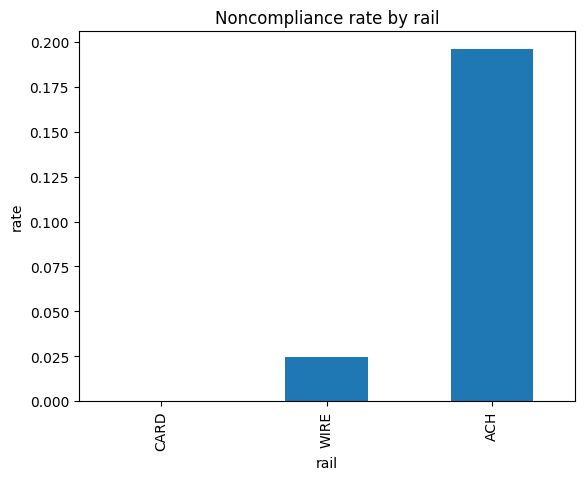

In [ ]:
import matplotlib.pyplot as plt

print("By account_type & rail:\n", df.groupby(["account_type","rail"]).size().unstack(fill_value=0))
print("\nClaims present by account_type:\n", df.assign(has_claim=df["claim_ts"].notna()).groupby("account_type")["has_claim"].mean().round(3))
print("\nNoncompliance rate overall:\n", df["noncompliant_label"].mean().round(3))

# Add non-compliance rate broken down by account type
print("\nNoncompliance rate by account_type:\n", df.groupby("account_type")["noncompliant_label"].mean().round(3))

nc_by_rail = df.groupby("rail")["noncompliant_label"].mean().sort_values()
plt.figure()
nc_by_rail.plot(kind="bar")
plt.title("Noncompliance rate by rail")
plt.xlabel("rail"); plt.ylabel("rate")
plt.show()


## 5) Consumer vs Commercial queries (adherence vs at-risk)


In [ ]:

from datetime import timedelta

def view_filter(account_type=None, adherence=None, days=None):
    v = df.copy()
    if account_type in ("CONSUMER","COMMERCIAL"):
        v = v[v["account_type"]==account_type]
    if adherence == "adherent":
        v = v[v["noncompliant_label"]==0]
    elif adherence == "at_risk":
        v = v[v["noncompliant_label"]==1]
    if days:
        cutoff = v["post_ts"].max() - pd.Timedelta(days=days)
        v = v[v["post_ts"]>=cutoff]
    return v

# Example output
view_filter(account_type="CONSUMER", adherence="at_risk", days=60).head(10)


,transaction_id,account_id,customer_id,account_type,rail,channel,mcc,amount,event_ts,post_ts,...,reg_e_notice_deadline,ach_return_deadline,rdfi_status_due,ucc4a_notice_deadline,consumer_notice_in_window,ach_return_in_window,rdfi_status_on_time,noncompliant_label,odfi_request_date,rdfi_status_due_bd
2,T0000002,A498653,C59244,CONSUMER,ACH,ACH_CCD,4812,94.58,2025-08-16 16:00:39+00:00,2025-08-18 17:00:39+00:00,...,2025-10-17 17:00:39+00:00,2025-10-17 17:00:39+00:00,2025-10-03 00:00:00+00:00,NaT,True,True,False,1,2025-09-21,2025-10-03
63,T0000063,A891117,C93893,CONSUMER,ACH,POS,4899,65.88,2025-08-21 04:35:36+00:00,2025-08-22 21:35:36+00:00,...,2025-10-21 21:35:36+00:00,2025-10-21 21:35:36+00:00,2025-09-10 00:00:00+00:00,NaT,True,True,False,1,2025-08-27,2025-09-10
75,T0000075,A708825,C58347,CONSUMER,ACH,ACH_WEB,5999,64.28,2025-08-28 14:04:15+00:00,2025-08-30 22:04:15+00:00,...,2025-10-29 22:04:15+00:00,2025-10-29 22:04:15+00:00,2025-11-14 00:00:00+00:00,NaT,True,True,False,1,2025-11-01,2025-11-14
83,T0000083,A992311,C61731,CONSUMER,ACH,P2P,5732,117.49,2025-08-26 12:50:11+00:00,2025-08-29 10:50:11+00:00,...,2025-10-28 10:50:11+00:00,2025-10-28 10:50:11+00:00,2025-11-21 00:00:00+00:00,NaT,False,False,True,1,2025-11-08,2025-11-21
88,T0000088,A105507,C68040,CONSUMER,ACH,ATM,4899,34.50,2025-08-29 15:39:21+00:00,2025-08-31 01:39:21+00:00,...,2025-10-30 01:39:21+00:00,2025-10-30 01:39:21+00:00,2025-09-19 00:00:00+00:00,NaT,True,True,False,1,2025-09-05,2025-09-19
104,T0000104,A423481,C73943,CONSUMER,ACH,POS,5732,79.42,2025-08-17 23:47:52+00:00,2025-08-18 21:47:52+00:00,...,2025-10-17 21:47:52+00:00,2025-10-17 21:47:52+00:00,2025-10-01 00:00:00+00:00,NaT,True,True,False,1,2025-09-17,2025-10-01
123,T0000123,A603030,C60159,CONSUMER,ACH,ATM,5732,22.84,2025-07-25 17:53:32+00:00,2025-07-28 13:53:32+00:00,...,2025-09-26 13:53:32+00:00,2025-09-26 13:53:32+00:00,2025-10-06 00:00:00+00:00,NaT,True,True,False,1,2025-09-22,2025-10-06
163,T0000163,A349496,C11357,CONSUMER,ACH,ACH_WEB,5812,84.14,2025-08-10 17:07:28+00:00,2025-08-12 03:07:28+00:00,...,2025-10-11 03:07:28+00:00,2025-10-11 03:07:28+00:00,NaT,NaT,False,False,True,1,None,None
168,T0000168,A191885,C66709,CONSUMER,ACH,P2P,5999,79.87,2025-08-30 11:40:05+00:00,2025-09-02 01:40:05+00:00,...,2025-11-01 01:40:05+00:00,2025-11-01 01:40:05+00:00,NaT,NaT,False,False,True,1,None,None
192,T0000192,A955850,C94267,CONSUMER,ACH,POS,5812,36.18,2025-08-11 04:56:41+00:00,2025-08-12 04:56:41+00:00,...,2025-10-11 04:56:41+00:00,2025-10-11 04:56:41+00:00,NaT,NaT,False,False,True,1,None,None



## 6) Timeline construction & inspection


In [ ]:

timeline = df.copy()
timeline["days_post_to_claim"] = (timeline["claim_ts"] - timeline["post_ts"]).dt.days
timeline["days_odfi_to_rdfi_status"] = (timeline["rdfi_status_ts"] - timeline["odfi_request_ts"]).dt.days

cols = ["transaction_id","account_type","rail","amount","post_ts","claim_ts","days_post_to_claim",
        "reg_e_notice_deadline","consumer_notice_in_window",
        "odfi_request_ts","rdfi_status_ts","days_odfi_to_rdfi_status","rdfi_status_due","rdfi_status_on_time",
        "noncompliant_label"]
timeline[cols].head(12)


,transaction_id,account_type,rail,amount,post_ts,claim_ts,days_post_to_claim,reg_e_notice_deadline,consumer_notice_in_window,odfi_request_ts,rdfi_status_ts,days_odfi_to_rdfi_status,rdfi_status_due,rdfi_status_on_time,noncompliant_label
0,T0000000,CONSUMER,WIRE,96.08,2025-08-04 16:10:12+00:00,2025-08-08 16:10:12+00:00,4.0,NaT,False,NaT,NaT,NaN,NaT,True,0
1,T0000001,COMMERCIAL,ACH,846.10,2025-07-02 16:00:29+00:00,NaT,NaN,NaT,False,NaT,NaT,NaN,NaT,True,0
2,T0000002,CONSUMER,ACH,94.58,2025-08-18 17:00:39+00:00,2025-09-18 17:00:39+00:00,31.0,2025-10-17 17:00:39+00:00,True,2025-09-21 17:00:39+00:00,2025-10-15 17:00:39+00:00,24.0,2025-10-03 00:00:00+00:00,False,1
3,T0000003,CONSUMER,ACH,41.47,2025-06-11 05:01:51+00:00,NaT,NaN,2025-08-10 05:01:51+00:00,False,NaT,NaT,NaN,NaT,True,0
4,T0000004,CONSUMER,WIRE,342.31,2025-06-17 21:34:39+00:00,2025-06-29 21:34:39+00:00,12.0,NaT,False,NaT,NaT,NaN,NaT,True,0
5,T0000005,COMMERCIAL,ACH,43.34,2025-09-13 06:23:28+00:00,NaT,NaN,NaT,False,NaT,NaT,NaN,NaT,True,0
6,T0000006,COMMERCIAL,ACH,68.22,2025-06-19 15:40:40+00:00,2025-07-21 15:40:40+00:00,32.0,NaT,False,2025-07-24 15:40:40+00:00,2025-07-30 15:40:40+00:00,6.0,2025-08-07 00:00:00+00:00,True,1
7,T0000007,COMMERCIAL,ACH,52.74,2025-08-12 11:14:01+00:00,NaT,NaN,NaT,False,NaT,NaT,NaN,NaT,True,0
8,T0000008,COMMERCIAL,ACH,78.65,2025-06-14 06:17:40+00:00,NaT,NaN,NaT,False,NaT,NaT,NaN,NaT,True,0
9,T0000009,CONSUMER,ACH,25.93,2025-09-08 19:49:18+00:00,NaT,NaN,2025-11-07 19:49:18+00:00,False,NaT,NaT,NaN,NaT,True,0



## 7) Feature engineering for risk scoring (XGBoost example)

**Label:** `noncompliant_label`  
**Features (examples):**
- Timing deltas (days)
- Context (rail/channel, account_type, ACH reason codes, wsud_present)
- Amount log scale
- ODFI/RDFI responsiveness


In [ ]:

import numpy as np

work = df.copy()
work["days_post_to_claim"] = (work["claim_ts"] - work["post_ts"]).dt.days.fillna(999).astype(int)
work["days_odfi_to_rdfi_status"] = (work["rdfi_status_ts"] - work["odfi_request_ts"]).dt.days.fillna(999).astype(int)
work["is_ach"] = (work["rail"]=="ACH").astype(int)
work["is_consumer"] = (work["account_type"]=="CONSUMER").astype(int)
work["amount_log"] = np.log1p(work["amount"])
work["wsud_present_i"] = work["wsud_present"].astype(int)
work["reason_R10"] = (work["reason_code"]=="R10").astype(int)
work["reason_R11"] = (work["reason_code"]=="R11").astype(int)
work["rdfi_status_on_time_i"] = work["rdfi_status_on_time"].astype(int)

feature_cols = ["days_post_to_claim","days_odfi_to_rdfi_status","is_ach","is_consumer","amount_log",
                "wsud_present_i","reason_R10","reason_R11","rdfi_status_on_time_i"]
X = work[feature_cols].values
y = work["noncompliant_label"].values

X.shape, float(y.mean())


((100000, 9), 0.13963)


## 8) Train & evaluate XGBoost (toy example)

> In Colab: `pip install xgboost`


In [ ]:
!pip -q install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, pred, digits=3))
print("ROC AUC:", round(roc_auc_score(y_test, proba), 3))

# Display the shape of the data used for training
print("\nShape of data used for training:", X_train.shape)

# Display feature importance in descending order
if hasattr(clf, 'feature_importances_'):
    importance = clf.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': feature_cols, 'importance': importance})
    print("\nFeature Importance (descending):")
    display(feature_importance_df.sort_values('importance', ascending=False))

              precision    recall  f1-score   support

           0      0.998     1.000     0.999     21509
           1      1.000     0.986     0.993      3491

    accuracy                          0.998     25000
   macro avg      0.999     0.993     0.996     25000
weighted avg      0.998     0.998     0.998     25000

ROC AUC: 1.0

Shape of data used for training: (75000, 9)

Feature Importance (descending):


,feature,importance
8,rdfi_status_on_time_i,0.522152
1,days_odfi_to_rdfi_status,0.247413
0,days_post_to_claim,0.075028
2,is_ach,0.067117
3,is_consumer,0.036678
5,wsud_present_i,0.021533
7,reason_R11,0.014782
6,reason_R10,0.014600
4,amount_log,0.000697



## 9) Score and rank cases by risk


In [ ]:
import pandas as pd

# Use the trained combined model (clf) to predict probabilities for the entire dataset (X)
risk_scores_proba = clf.predict_proba(X)[:, 1]

# Create a DataFrame for risk scores using transaction_id from the original work dataframe
risk_scores = pd.DataFrame({
    "transaction_id": work["transaction_id"],
    "risk_score": risk_scores_proba
})

# Sort the DataFrame by risk score in descending order
risk_scores = risk_scores.sort_values("risk_score", ascending=False)

# Display the top 15 highest risk transactions
display(risk_scores.head(15))

,transaction_id,risk_score
75562,T0075562,0.999999
77841,T0077841,0.999999
29995,T0029995,0.999998
64645,T0064645,0.999998
33033,T0033033,0.999998
97324,T0097324,0.999998
97906,T0097906,0.999998
1491,T0001491,0.999998
98342,T0098342,0.999998
19277,T0019277,0.999998



--- Training and evaluating on Combined ACH/Wire data ---
Shape of data used: (100000, 9)
Shape of training data: (75000, 9)

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     21462
           1      1.000     1.000     1.000      3538

    accuracy                          1.000     25000
   macro avg      1.000     1.000     1.000     25000
weighted avg      1.000     1.000     1.000     25000

ROC AUC: 1.0

Confusion Matrix:


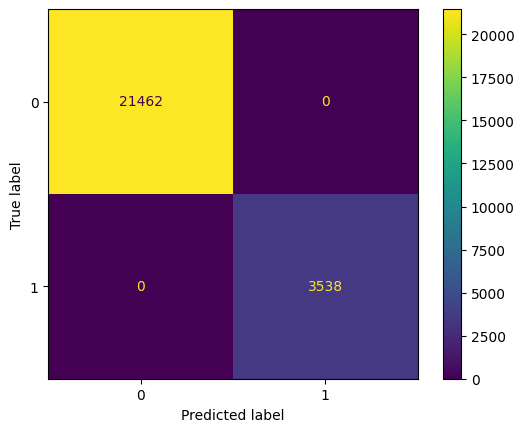


Feature Importance (descending):


,feature,importance
6,rdfi_status_on_time_i,0.513281
1,days_odfi_to_rdfi_status,0.285968
7,ucc4a_applicable_i,0.062676
0,days_post_to_claim,0.059390
8,reg_e_applicable_i,0.041952
3,wsud_present_i,0.029952
5,reason_R11,0.003947
4,reason_R10,0.002685
2,amount_log,0.000149



--- Training and evaluating on ACH Consumer data ---
Shape of data used: (45517, 8)
Shape of training data: (34137, 8)

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      8893
           1      1.000     1.000     1.000      2487

    accuracy                          1.000     11380
   macro avg      1.000     1.000     1.000     11380
weighted avg      1.000     1.000     1.000     11380

ROC AUC: 1.0

Confusion Matrix:


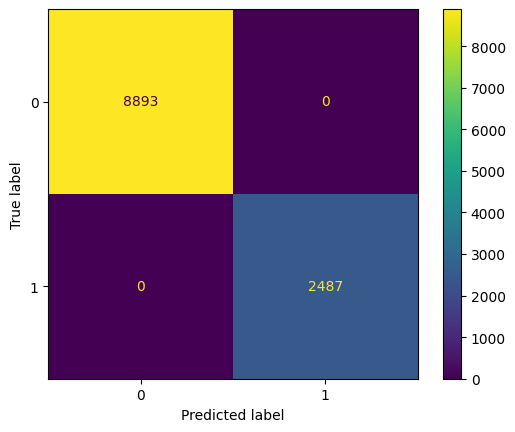


Feature Importance (descending):


,feature,importance
1,days_odfi_to_rdfi_status,0.361936
6,rdfi_status_on_time_i,0.313693
0,days_post_to_claim,0.186669
3,wsud_present_i,0.118675
4,reason_R10,0.011016
5,reason_R11,0.007357
2,amount_log,0.000654
7,reg_e_applicable_i,0.000000



--- Training and evaluating on ACH Commercial data ---
Shape of data used: (24465, 8)
Shape of training data: (18348, 8)

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      5127
           1      1.000     1.000     1.000       990

    accuracy                          1.000      6117
   macro avg      1.000     1.000     1.000      6117
weighted avg      1.000     1.000     1.000      6117

ROC AUC: 1.0

Confusion Matrix:


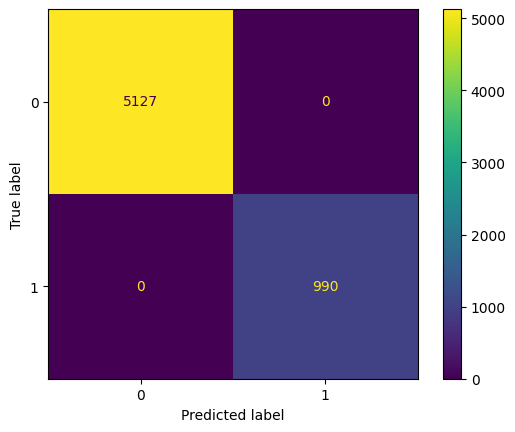


Feature Importance (descending):


,feature,importance
1,days_odfi_to_rdfi_status,0.440656
0,days_post_to_claim,0.316555
6,rdfi_status_on_time_i,0.148751
5,reason_R11,0.047834
4,reason_R10,0.043652
2,amount_log,0.002551
3,wsud_present_i,0.000000
7,ucc4a_applicable_i,0.000000



--- Training and evaluating on Wire Consumer data ---
Shape of data used: (6537, 3)
Skipping Wire Consumer: Training data does not contain both compliant and non-compliant cases.

--- Training and evaluating on Wire Commercial data ---
Shape of data used: (3503, 3)
Shape of training data: (2627, 3)

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       815
           1      1.000     1.000     1.000        61

    accuracy                          1.000       876
   macro avg      1.000     1.000     1.000       876
weighted avg      1.000     1.000     1.000       876

ROC AUC: 1.0

Confusion Matrix:


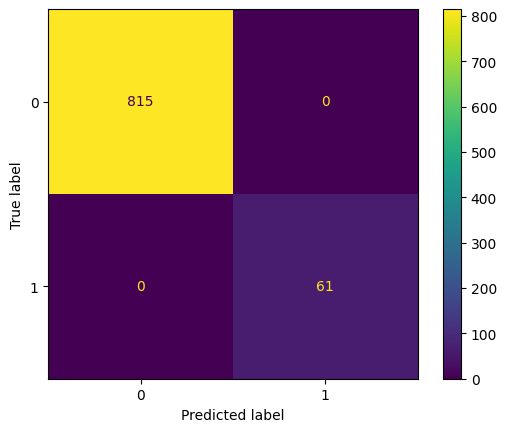


Feature Importance (descending):


,feature,importance
0,days_post_to_claim,0.996604
1,amount_log,0.003396
2,ucc4a_applicable_i,0.000000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prepare data for different subsets
work = df.copy()

# Engineer features
work["days_post_to_claim"] = (work["claim_ts"] - work["post_ts"]).dt.days.fillna(-1).astype(int) # Use -1 for no claim
work["days_odfi_to_rdfi_status"] = (work["rdfi_status_ts"] - work["odfi_request_ts"]).dt.days.fillna(-1).astype(int) # Use -1 for no request/status
work["is_ach"] = (work["rail"]=="ACH").astype(int)
work["is_consumer"] = (work["account_type"]=="CONSUMER").astype(int)
work["amount_log"] = np.log1p(work["amount"])
work["wsud_present_i"] = work["wsud_present"].astype(int)
work["reason_R10"] = (work["reason_code"]=="R10").astype(int)
work["reason_R11"] = (work["reason_code"]=="R11").astype(int)
work["rdfi_status_on_time_i"] = work["rdfi_status_on_time"].astype(int)
work["ucc4a_applicable_i"] = work["ucc4a_applicable"].astype(int)
work["reg_e_applicable_i"] = work["reg_e_applicable"].astype(int)


# Define feature column names for combined data
# Exclude is_ach and is_consumer as requested for combined feature importance display
feature_cols_combined = [
    "days_post_to_claim",
    "days_odfi_to_rdfi_status",
    "amount_log",
    "wsud_present_i",
    "reason_R10",
    "reason_R11",
    "rdfi_status_on_time_i",
    "ucc4a_applicable_i",
    "reg_e_applicable_i"
]

# Create boolean masks for subsets
ach_mask = work["rail"] == "ACH"
wire_mask = work["rail"] == "WIRE"
consumer_mask = work["account_type"] == "CONSUMER"
commercial_mask = work["account_type"] == "COMMERCIAL"

# Create data subsets
df_combined = work.copy()
df_ach_consumer = work[ach_mask & consumer_mask].copy()
df_ach_commercial = work[ach_mask & commercial_mask].copy()
df_wire_consumer = work[wire_mask & consumer_mask].copy()
df_wire_commercial = work[wire_mask & commercial_mask].copy()

# Define feature column names for each subset
# ACH Consumer: Features relevant to ACH and Consumer, including Reg E applicable, excluding rail/account type flags
feature_cols_ach_consumer = [
    "days_post_to_claim",
    "days_odfi_to_rdfi_status",
    "amount_log",
    "wsud_present_i",
    "reason_R10",
    "reason_R11",
    "rdfi_status_on_time_i",
    "reg_e_applicable_i"
]

# ACH Commercial: Features relevant to ACH and Commercial, including UCC4A applicable, excluding rail/account type flags
feature_cols_ach_commercial = [
    "days_post_to_claim",
    "days_odfi_to_rdfi_status",
    "amount_log",
    "wsud_present_i",
    "reason_R10",
    "reason_R11",
    "rdfi_status_on_time_i",
    "ucc4a_applicable_i"
]

# Wire Consumer: Features relevant to Wire and Consumer, excluding rail/account type flags and ACH specifics
feature_cols_wire_consumer = [
    "days_post_to_claim",
    "amount_log",
    "reg_e_applicable_i" # Reg E doesn't directly apply to Wire, but keep flag for context if needed
]

# Wire Commercial: Features relevant to Wire and Commercial, including UCC4A applicable, excluding rail/account type flags and ACH specifics
feature_cols_wire_commercial = [
    "days_post_to_claim",
    "amount_log",
    "ucc4a_applicable_i"
]


# Extract features (X) and target (y) for each subset
X_combined = df_combined[feature_cols_combined].values
y_combined = df_combined["noncompliant_label"].values

X_ach_consumer = df_ach_consumer[feature_cols_ach_consumer].values
y_ach_consumer = df_ach_consumer["noncompliant_label"].values

X_ach_commercial = df_ach_commercial[feature_cols_ach_commercial].values
y_ach_commercial = df_ach_commercial["noncompliant_label"].values

X_wire_consumer = df_wire_consumer[feature_cols_wire_consumer].values
y_wire_consumer = df_wire_consumer["noncompliant_label"].values

X_wire_commercial = df_wire_commercial[feature_cols_wire_commercial].values
y_wire_commercial = df_wire_commercial["noncompliant_label"].values


# Define function to train and evaluate XGBoost model
def train_and_evaluate_model(X_data, y_data, feature_names, subset_name):
    print(f"\n--- Training and evaluating on {subset_name} data ---")
    print("Shape of data used:", X_data.shape)

    if X_data.shape[0] == 0:
        print(f"No data available for {subset_name}.")
        return

    # Check if there are both classes in the training data subset
    if len(np.unique(y_data)) < 2:
        print(f"Skipping {subset_name}: Training data does not contain both compliant and non-compliant cases.")
        return

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42, stratify=y_data)

    print("Shape of training data:", X_train.shape)


    clf = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    proba = clf.predict_proba(X_test)[:,1]

    print("\nClassification Report:")
    print(classification_report(y_test, pred, digits=3))
    print("ROC AUC:", round(roc_auc_score(y_test, proba), 3))

    # Confusion Matrix
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    print("\nConfusion Matrix:")
    disp.plot()
    plt.show()


    # Feature Importance
    if hasattr(clf, 'feature_importances_'):
        importance = clf.feature_importances_
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
        print("\nFeature Importance (descending):")
        display(feature_importance_df.sort_values('importance', ascending=False))

    return clf # Return the trained model for SHAP analysis later


# Train and evaluate models on each subset and store models
clf_combined = train_and_evaluate_model(X_combined, y_combined, feature_cols_combined, "Combined ACH/Wire")
clf_ach_consumer = train_and_evaluate_model(X_ach_consumer, y_ach_consumer, feature_cols_ach_consumer, "ACH Consumer")
clf_ach_commercial = train_and_evaluate_model(X_ach_commercial, y_ach_commercial, feature_cols_ach_commercial, "ACH Commercial")
clf_wire_consumer = train_and_evaluate_model(X_wire_consumer, y_wire_consumer, feature_cols_wire_consumer, "Wire Consumer")
clf_wire_commercial = train_and_evaluate_model(X_wire_commercial, y_wire_commercial, feature_cols_wire_commercial, "Wire Commercial")

In [ ]:
!pip -q install shap


SHAP Summary Plot:


/tmp/ipython-input-22-3357912245.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_data_for_shap, feature_names=feature_names_for_shap)


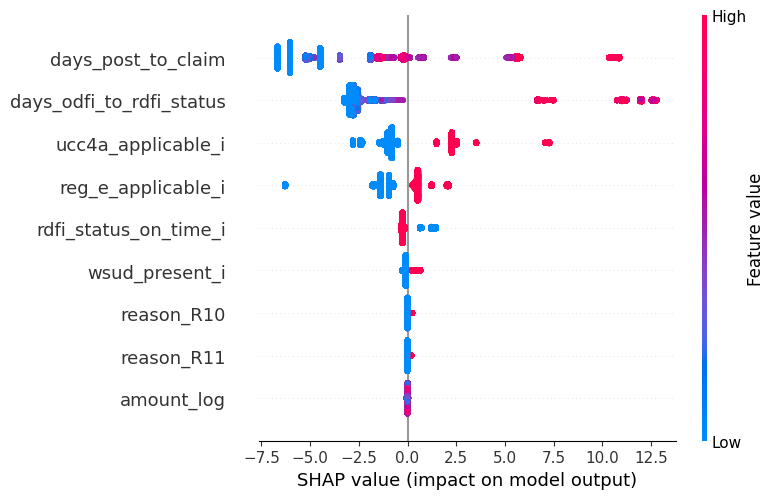

In [ ]:
import shap

# Choose a model for SHAP analysis, e.g., the combined model
# You can replace clf_combined with clf_ach_consumer, clf_ach_commercial, etc.
# depending on which model you want to explain.
model_to_explain = clf_combined
X_data_for_shap = X_combined # Use the corresponding data for the chosen model
feature_names_for_shap = feature_cols_combined

if model_to_explain and X_data_for_shap.shape[0] > 0:
    # Create a SHAP explainer
    explainer = shap.TreeExplainer(model_to_explain)

    # Calculate SHAP values (using a sample of the data for faster computation if needed)
    # shap_values = explainer.shap_values(X_data_for_shap[:1000]) # Use [:1000] for a sample
    shap_values = explainer.shap_values(X_data_for_shap) # Use all data (can be slow for large datasets)

    # Summarize the effects of all features
    print("\nSHAP Summary Plot:")
    shap.summary_plot(shap_values, X_data_for_shap, feature_names=feature_names_for_shap)

    # Plot the SHAP values for a single instance (e.g., the first instance in the data)
    # print("\nSHAP Force Plot for the first instance:")
    # shap.initjs()
    # shap.force_plot(explainer.expected_value, shap_values[0,:], X_data_for_shap[0,:], feature_names=feature_names_for_shap)

else:
    print("Model or data not available for SHAP analysis.")

## Summary of Model Performance and Insights

Based on the classification reports, ROC AUC scores, feature importances, and SHAP values (if calculated), here is a summary of the model performance across the different subsets and key insights:

*(After running the code cells above, review the outputs and fill in this section with your observations. Discuss the performance of each model, the most important features for predicting non-compliance in each subset, and any insights gained from the SHAP analysis about how specific feature values influence the predictions.)*

**Overall Performance:**

*(Summarize the performance metrics - Accuracy, Precision, Recall, F1-score, ROC AUC - for the Combined, ACH Consumer, ACH Commercial, Wire Consumer, and Wire Commercial models. Note if any models still show perfect or near-perfect performance and what that might imply about the data.)*

**Key Feature Importances:**

*(Discuss the top features for each model based on the feature importance plots. Explain what these features represent in the context of banking transactions and compliance rules. Compare and contrast the important features across the different subsets - e.g., how do the key drivers of non-compliance differ between ACH Consumer and ACH Commercial, or between ACH and Wire?)*

**SHAP Insights:**

*(If you ran the SHAP analysis, discuss what the SHAP summary plot and potentially individual force plots reveal about how features collectively and individually impact the model's predictions. Are there specific feature values that consistently push predictions towards non-compliant? Do the SHAP results align with the feature importance rankings?)*

**Implications and Next Steps:**

*(Based on the model performance and insights, what are the implications for identifying and managing non-compliant transactions? What are the next steps? Consider whether further data adjustments are needed, exploring other models, refining features, or applying these insights to real-world data.)*


## 10) Generative AI — Gemini (optional)

**Use cases:**
1) Summarize observed vs benchmark metrics over a date window.
2) Answer questions like: "Show consumer vs commercial adherence last 45 days; list top at-risk patterns."

**Setup in Colab:**
```python
!pip -q install google-generativeai
import os, google.generativeai as genai
os.environ["GOOGLE_API_KEY"] = "YOUR_KEY_HERE"
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
```


In [ ]:
!pip -q install google-generativeai
import os, google.generativeai as genai
os.environ["GOOGLE_API_KEY"] = "GOOGLE_API_KEY"  # ENTER GOOGLE API KEY " in quotes "
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [ ]:

# Example: build a compact JSON summary that you can feed to Gemini
def aggregate_summary(df, days=45):
    cutoff = df["post_ts"].max() - pd.Timedelta(days=days)
    v = df[df["post_ts"]>=cutoff]
    out = {
        "window_days": days,
        "n_tx": int(v.shape[0]),
        "n_claims": int(v["claim_ts"].notna().sum()),
        "noncompliance_rate": float(v["noncompliant_label"].mean()),
        "consumer_noncomp": float(v.loc[v["account_type"]=="CONSUMER","noncompliant_label"].mean() if (v["account_type"]=="CONSUMER").any() else float('nan')),
        "commercial_noncomp": float(v.loc[v["account_type"]=="COMMERCIAL","noncompliant_label"].mean() if (v["account_type"]=="COMMERCIAL").any() else float('nan')),
        "benchmarks": BENCHMARKS,
        "observed": OBS
    }
    return out

summary = aggregate_summary(df, days=45)
summary


{'window_days': 45,
 'n_tx': 41326,
 'n_claims': 15202,
 'noncompliance_rate': 0.14221071480423947,
 'consumer_noncomp': 0.15364959448950116,
 'commercial_noncomp': 0.12064511624659638,
 'benchmarks': {'target_recovery_rate_overall': 0.25,
  'target_consumer_notice_adherence': 0.95,
  'target_rdfi_status_on_time': 0.9},
 'observed': {'recovery_attempt_share': 0.15299,
  'observed_recovery_rate_overall': 0.201908621478528,
  'consumer_notice_adherence': 0.3062170333914502,
  'rdfi_status_on_time': 0.4355840250996797}}

In [ ]:
import google.generativeai as genai
import pandas as pd
import json

# Initialize the Generative Model (assuming API key is set in a previous cell)
try:
    gemini_model = genai.GenerativeModel('gemini-1.5-flash-latest') # Use a suitable model name
except Exception as e:
    print(f"Could not initialize Gemini model: {e}")
    print("Please ensure your GOOGLE_API_KEY is set correctly and the model name is valid.")
    gemini_model = None

if gemini_model:
    # --- Part 1: Generate a detailed summary ---

    # Prepare data points for the summary
    data_summary = {
        "Total Transactions": int(df.shape[0]),
        "Transactions by Account Type and Rail": df.groupby(["account_type","rail"]).size().unstack(fill_value=0).to_dict(),
        "Claims Present by Account Type Share": df.assign(has_claim=df["claim_ts"].notna()).groupby("account_type")["has_claim"].mean().round(3).to_dict(),
        "Overall Noncompliance Rate": float(df["noncompliant_label"].mean().round(3)),
        "Noncompliance Rate by Account Type": df.groupby("account_type")["noncompliant_label"].mean().round(3).to_dict(),
        "Benchmarks": BENCHMARKS,
        "Observed Metrics": OBS,
        # Add exposure analysis (illustrative - sum of amount for non-compliant cases)
        "Total Amount of Non-Compliant Transactions": float(df[df["noncompliant_label"] == 1]["amount"].sum().round(2)),
        "Average Amount of Non-Compliant Transactions": float(df[df["noncompliant_label"] == 1]["amount"].mean().round(2)) if (df["noncompliant_label"] == 1).any() else 0.0,
         # Get top features from the combined model if available
        "Top Features (Combined Model)": feature_importance_df.sort_values('importance', ascending=False).head(5).to_dict(orient='records') if 'feature_importance_df' in globals() else "Run ML section first"

    }

    summary_prompt = f"""
    Act as a risk and compliance professional analyst reviewing a synthetic dataset of bank transactions and recoveries.
    Analyze the following data summary and provide a concise report covering:
    1.  **Descriptive Statistics:** Summarize the transaction volume by rail (ACH, Card, Wire) and account type (Consumer, Commercial).
    2.  **Recovery and Compliance Metrics:** Report on the share of transactions with claims, overall recovery attempt share, observed overall recovery rate (among those with status), consumer notice adherence (Reg E), and RDFI status on-time rate (Nacha). Compare observed metrics to benchmarks where provided.
    3.  **Non-compliance Overview:** State the overall non-compliance rate and break it down by account type (Consumer vs Commercial).
    4.  **Exposure Analysis:** Based on the non-compliant transactions, report the total and average amount exposed (illustrative of potential unrecovered funds or losses due to non-compliance).
    5.  **Feature Insights (Proactive):** Based on the provided top features from the risk scoring model, discuss which features appear most important for identifying non-compliant transactions. Suggest how understanding these features proactively can help in preventing or mitigating non-compliance issues in the future.

    Here is the data summary in JSON format:
    {json.dumps(data_summary, indent=2)}

    Focus on providing a clear, actionable summary from a risk and compliance perspective.
    """

    print("Generating detailed summary...")
    try:
        response = gemini_model.generate_content(summary_prompt)
        print("\n--- Detailed Summary ---")
        print(response.text)
    except Exception as e:
        print(f"Error generating summary: {e}")


else:
    print("Skipping summary generation as Gemini model could not be initialized.")

Generating detailed summary...

--- Detailed Summary ---
## Bank Transaction and Recovery Risk & Compliance Report

**1. Descriptive Statistics:**

Total transactions processed: 100,000

Transaction Volume by Rail and Account Type:

| Rail   | Consumer | Commercial | Total |
|--------|----------|------------|-------|
| ACH    | 45,517    | 24,465      | 69,982 |
| Card   | 12,977    | 7,001       | 19,978 |
| Wire   | 6,537     | 3,503       | 10,040 |
| **Total** | **65,031** | **34,969** | **100,000** |


**2. Recovery and Compliance Metrics:**

| Metric                               | Observed Value             | Benchmark      | Status             |
|---------------------------------------|---------------------------|-----------------|---------------------|
| Claims Present Share (Commercial)     | 30.1%                      | N/A             |                   |
| Claims Present Share (Consumer)        | 40%                       | N/A             |                    |
| Recover

In [ ]:
# --- Part 2: Create an interactive chatbot ---

if gemini_model:
    print("\n--- Interactive Chatbot (Risk/Compliance/Fraud Analyst) ---")
    print("You can now ask questions about the data. Type 'quit' to exit.")

    # Pass the dataframe and summary data to the model for context
    chat_context = f"""
    You are a helpful AI assistant for a risk and compliance professional analyst.
    You have access to a synthetic dataset of bank transactions and recoveries.
    Here is a summary of the data and key metrics:
    {json.dumps(data_summary, indent=2) if 'data_summary' in globals() else 'Data summary not available.'}

    You can answer questions about the data, transaction volumes, compliance metrics, recovery status, non-compliant cases, and the factors influencing risk based on the provided feature importance.

    Answer the user's questions based on the context provided. If you cannot answer from the provided data, state that you don't have enough information.
    """

    chat = gemini_model.start_chat(history=[])
    chat.send_message(chat_context) # Send context to the model

    # Illustrative questions for the user (as comments)
    # # What is the total number of transactions and how are they split by rail?
    # # What is the overall non-compliance rate?
    # # How does the non-compliance rate differ between consumer and commercial accounts?
    # # What is the observed recovery rate compared to the target benchmark?
    # # What are the most important features for predicting non-compliance according to the model?
    # # What is the total amount exposed in non-compliant transactions?
    # # Can you tell me about the consumer notice adherence rate?

    while True:
        user_input = input("\nAsk a question about the data: ")
        if user_input.lower() == 'quit':
            break
        if user_input.strip():
            try:
                response = chat.send_message(user_input)
                print(f"\nAI Analyst: {response.text}")
            except Exception as e:
                 print(f"Error getting response from AI Analyst: {e}")
        else:
            print("Please enter a question.")

else:
    print("Skipping chatbot as Gemini model could not be initialized.")


--- Interactive Chatbot (Risk/Compliance/Fraud Analyst) ---
You can now ask questions about the data. Type 'quit' to exit.

Ask a question about the data: How does the non-compliance rate differ between consumer and commercial accounts?

AI Analyst: The non-compliance rate is higher for consumer accounts (15.3%) than for commercial accounts (12%).



KeyboardInterrupt: Interrupted by user